<a href="https://colab.research.google.com/github/EduardoSaverin/Colabs/blob/master/Bird_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing all required libraries

In [1]:
import tensorflow as tf
import PIL
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Mount Drive Using


```
from google.colab import drive
drive.mount('/content/drive')
```

And then copy path and append prefix `file://`



In [ ]:
dataset_url = "file:///content/drive/My Drive/Colab Notebooks/Datasets/images.tar.gz"
data_dir = tf.keras.utils.get_file("images", origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

678223872/678221918 [==============================] - 6s 0us/step


Total Image Count : 6033

In [ ]:
image_count = len(list(data_dir.glob("*/*.jpg")))
print(image_count)

6033


Showing Sample Image From American GoldFinch

/root/.keras/datasets/images/    American Goldfinch/American_Goldfinch_0017_495390271.jpg


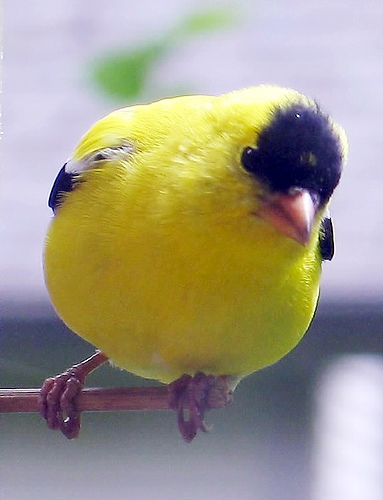

In [ ]:
goldfinch = list(data_dir.glob("    American Goldfinch/*"))
for image in data_dir.glob("*/*.jpg"):
  PIL.Image.open(image)
print(goldfinch[0])
PIL.Image.open(goldfinch[0])

### **Starting Training of Model**

In [ ]:
batch_size = 32
image_height = 200
image_width = 200

Creating training dataset

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory = data_dir,
    batch_size=batch_size,
    image_size=(image_height, image_width),
    validation_split=0.2,
    subset="training",
    seed=101
)

Found 6033 files belonging to 200 classes.
Using 4827 files for training.


Creating validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory = data_dir,
    batch_size=batch_size,
    image_size=(image_height, image_width),
    validation_split=0.2,
    subset="validation",
    seed=101
)

Found 6033 files belonging to 200 classes.
Using 1206 files for validation.


Total 200 classes found - which is correct since images folder contains 200 subfolders

In [ ]:
class_names = train_ds.class_names
print(class_names)

['    Acadian Flycatcher', '    American Crow', '    American Goldfinch', '    American Pipit', '    American Redstart', '    American Three toed Woodpecker', '    Anna Hummingbird', '    Artic Tern', '    Baird Sparrow', '    Baltimore Oriole', '    Bank Swallow', '    Barn Swallow', '    Bay breasted Warbler', '    Belted Kingfisher', '    Bewick Wren', '    Black Tern', '    Black and white Warbler', '    Black billed Cuckoo', '    Black capped Vireo', '    Black footed Albatross', '    Black throated Blue Warbler', '    Black throated Sparrow', '    Blue Grosbeak', '    Blue Jay', '    Blue headed Vireo', '    Blue winged Warbler', '    Boat tailed Grackle', '    Bohemian Waxwing', '    Brandt Cormorant', '    Brewer Blackbird', '    Brewer Sparrow', '    Bronzed Cowbird', '    Brown Creeper', '    Brown Pelican', '    Brown Thrasher', '    Cactus Wren', '    California Gull', '    Canada Warbler', '    Cape Glossy Starling', '    Cape May Warbler', '    Carolina Wren', '    Caspia

Here `take()` method of training dataset gets one batch of the all batches that got created. If you inspect length of `len(labels)` then you will get 32 that's the same size of `batch_size`

32


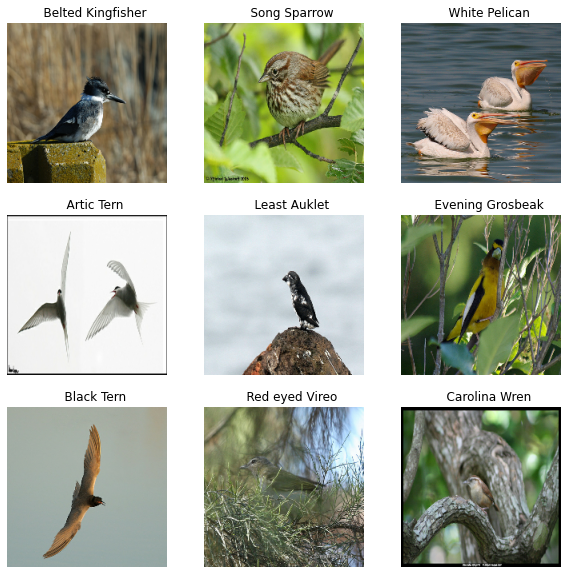

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  print(len(labels))
  for i in range(9):
    ax = plt.subplot(3,3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The *image_batch* is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension referes to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images. 

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 200, 200, 3)
(32,)


Using buffered prefetching so we can yield data from disk without having I/O become blocking. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Standardize the data
The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, we will standardize values to be in the `[0, 1]` by using a Rescaling layer.

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

# Creating Model

In [ ]:
num_classes = 200

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
  layers.MaxPooling2D(pool_size=3, strides=2, padding="same"),

  layers.Conv2D(64, kernel_size=7, strides=(2,2), padding="same"),
  layers.BatchNormalization(64, momentum=0.1),
  layers.MaxPooling2D(pool_size=3, strides=2, padding="same"),

  layers.Conv2D(128, kernel_size=7, strides=(2,2), padding="same"),
  layers.BatchNormalization(64, momentum=0.1),
  layers.MaxPooling2D(pool_size=3, strides=2, padding="same"),

  layers.Conv2D(128, kernel_size=7, strides=(2,2), padding="same"),
  layers.BatchNormalization(64, momentum=0.1),
  layers.MaxPooling2D(pool_size=3, strides=2, padding="same"),

  layers.Conv2D(128, kernel_size=7, strides=(2,2), padding="same"),
  layers.BatchNormalization(64, momentum=0.1),
  layers.MaxPooling2D(pool_size=3, strides=2, padding="same"),

  layers.Conv2D(200, kernel_size=7, strides=(2,2), padding="same"),
  layers.BatchNormalization(64, momentum=0.1),
  layers.MaxPooling2D(pool_size=3, strides=2, padding="same"),

  layers.Flatten(),
  layers.Dense(num_classes, activation="sigmoid")
])


ValueError: ignored

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalHinge(),
              metrics=['accuracy'])


In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 200, 200, 3)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 98, 98, 200)       5600      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 200)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 200)       360200    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 200)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 100)       1

In [ ]:
epochs=10
history = model.fit(
  normalized_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/10
151/151 [==============================] - 21s 141ms/step - loss: 0.0078 - accuracy: 0.0033 - val_loss: 0.0137 - val_accuracy: 0.0058
Epoch 2/10
151/151 [==============================] - 21s 137ms/step - loss: 0.0077 - accuracy: 0.0044 - val_loss: 0.0137 - val_accuracy: 0.0058
Epoch 3/10
151/151 [==============================] - 21s 136ms/step - loss: 0.0077 - accuracy: 0.0050 - val_loss: 0.0136 - val_accuracy: 0.0066
Epoch 4/10
151/151 [==============================] - 21s 137ms/step - loss: 0.0077 - accuracy: 0.0052 - val_loss: 0.0136 - val_accuracy: 0.0058
Epoch 5/10
151/151 [==============================] - 21s 138ms/step - loss: 0.0077 - accuracy: 0.0033 - val_loss: 0.0136 - val_accuracy: 0.0050
Epoch 6/10
151/151 [==============================] - 21s 136ms/step - loss: 0.0077 - accuracy: 0.0033 - val_loss: 0.0135 - val_accuracy: 0.0058
Epoch 7/10
151/151 [==============================] - 21s 136ms/step - loss: 0.0077 - accuracy: 0.0050 - val_loss: 0.0135 - val_ac